# Local Background Estimators in opticam_new

`opticam_new` supports specification of local background estimators, which can improve the background estimation in cases where the background varies considerably across an image. In this notebook, I will demonstrate how to define a local background estimator for use with `opticam_new`, as well as explain `opticam_new`'s default behaviour when no local background estimator is specified.

## Test Image

First thing's first, let's open an image so we can compute the local background around each source. For this example, I'll use one of the images from the Basic Usage tutorial:

In [1]:
from astropy.io import fits
import numpy as np

with fits.open("Data/g-band_image_0.fits") as hdul:
    print(repr(hdul[0].header))
    image = np.array(hdul[0].data)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
EXTEND  =                    T                                                  
FILTER  = 'g       '                                                            
BINNING = '8x8     '                                                            
GAIN    =                  1.0                                                  
UT      = '2024-01-01 00:00:00'                                                 


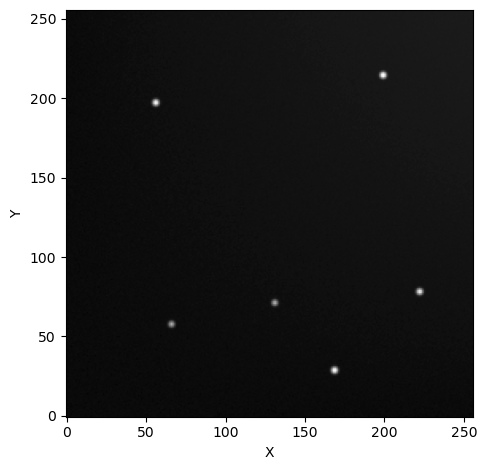

In [2]:
from astropy.visualization import simple_norm
from matplotlib import pyplot as plt

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(image, norm=simple_norm(image, stretch="sqrt"), origin="lower", cmap="Greys_r")

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

## Default Local Background

Before using the default local background estimator, we first need to find the positions of the sources in the above image:

In [3]:
from opticam_new import Finder

from photutils.segmentation import SourceCatalog, detect_threshold

finder = Finder(npixels=8, border_width=8)
segm = finder(image, detect_threshold(image, nsigma=5))
tbl = SourceCatalog(image, segm).to_table()

tbl

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,168.48273602805995,28.93378939032423,None,166,171,26,31,28.0,1.0120653668306643,1.0035710664466952,-1.2656895938377548,0.12928893079290274,1995.6858356346074,75874.43057074834,0.0,552168.6884188098,nan,591725.4578541403,nan
2,65.93662460418614,57.94545986007891,None,64,68,56,60,21.0,0.9845879493883379,0.9824632828806057,63.625894328778244,0.06565967150287626,2920.126771708993,30087.546176025022,0.0,200061.69620395853,nan,285708.5065368866,nan
3,130.90261217773784,71.35931886177232,None,129,133,69,74,24.0,1.0279126786387214,1.0062817514484104,-88.34569717435899,0.20406925327103995,1989.6488422304226,29607.10508936263,0.0,216050.96357619873,nan,312620.1632998367,nan
4,221.970883924268,78.4097344010445,None,219,224,76,81,27.0,1.0270317572044243,0.9997836349822273,84.80093337763222,0.22881869976529642,1965.7048901971139,62723.184338679,0.0,445330.14470667904,nan,503321.80346330017,nan
5,56.05552098844871,197.28937030619701,None,53,59,195,200,31.0,1.0355725079571618,1.0279115878598597,38.523666203070874,0.12141169351163954,1840.9629443243903,74721.58877581081,0.0,512874.52588376513,nan,560049.1591730033,nan
6,198.98766858575092,214.55156294074126,None,196,202,212,217,34.0,1.0565318644419044,1.048499239253632,-1.7126928493855045,0.12307657733485017,1872.738440668,86088.85206896291,0.0,632756.8132843126,nan,693233.2461852545,nan


In [4]:
coords = [(x, y) for x, y in zip(tbl['xcentroid'], tbl['ycentroid'])]
radius = 5 * tbl['semimajor_sigma'].value.max()

In [5]:
from opticam_new import CircularLocalBackground

from photutils.aperture import CircularAperture, aperture_photometry

error = np.sqrt(image)  # Poisson noise

aperture = CircularAperture(coords[0], r=radius)
aperture_area = aperture.area_overlap(image)
phot_table = aperture_photometry(image, aperture, error=error)

local_background = CircularLocalBackground(r_in_scale=1, r_out_scale=2)
local_bkg_per_pix, local_bkg_err_per_pix = local_background(data=image, error=error, semimajor_axis=radius,
                                                            semiminor_axis=radius, theta=0, position=coords[0])
local_bkg, local_bkg_err = aperture_area * local_bkg_per_pix, np.sqrt(aperture_area * local_bkg_err_per_pix)

flux = phot_table['aperture_sum'].value[0] - local_bkg
flux_err = np.sqrt(phot_table['aperture_sum_err'].value[0]**2 + local_bkg_err**2)


print(f'Source position: ({coords[0][0]:.0f}, {coords[0][1]:.0f})')
print(f'Raw flux: {phot_table['aperture_sum'].value[0]:.0f} +- {phot_table["aperture_sum_err"].value[0]:.0f} counts')
print(f'Background contribution: {local_bkg:.0f} +- {local_bkg_err:.0f} counts')
print(f'Background subtracted flux: {flux:.0f} +- {flux_err:.0f} counts')

Source position: (168, 29)
Raw flux: 620669 +- 788 counts
Background contribution: 91968 +- 54 counts
Background subtracted flux: 528701 +- 790 counts


As we can see, the local background estimator reduces the source flux by about 90,000 counts. Let's compare this to estimating the background globally using a two-dimensional background:

In [6]:
from opticam_new import Background

from photutils.utils import calc_total_error

background = Background(box_size=8)

bkg = background(image).background
bkg_err = background(image).background_rms

clean_image = image - bkg

error = calc_total_error(clean_image, bkg_err, effective_gain=1.)

phot_table = aperture_photometry(clean_image, aperture, error=error)

flux = phot_table['aperture_sum'].value[0]
flux_err = phot_table['aperture_sum_err'].value[0]

print(f'Global background subtracted flux: {flux:.0f} +- {flux_err:.0f} counts')

Global background subtracted flux: 528815 +- 785 counts


As we can see, the global background estimation is very similar to the local estimation. This is because the background in these synthetic data is smoothly varying, making both methods perform similarly. With real data, however, the differences between the two methods can be significant.

## Custom Local Backgrounds

Let's now define a custom local background estimator. Custom local background estimators should either inherit from the base `LocalBackground` class, or correctly implement a `__call__()` method. The `__call__()` method must implement the following paramters in the following order:
- `data`: the image data as a `NumPy` array.
- `error`: the error array.
- `semimajor_axis`: the semi-major axis of the annulus. This parameter is required even for circular annuli for consistency.
- `semiminor_axis`: the semi-minor axis of the annulus. This parameter is required even for circular annuli for consistency.
` 'theta`: the orientation angle of the annulus. This parameter is required even for circular annuli for consistency.

I recommend inheriting from the `LocalBackground` base class, since this ensures that the parameters are implemented in the correct order. Moreover, the base class also implements the `__init__()` method for us. For this example, we will implement an elliptical local background estimator that behaves similarly to the SExtractor algorithm. For convenience, we will inherit from the `LocalBackground` base class:

In [7]:
from opticam_new import LocalBackground

from photutils.aperture import EllipticalAnnulus, ApertureStats

class CustomLocalBackground(LocalBackground):
    
    def __call__(self, data, error, semimajor_axis, semiminor_axis, theta, position):
        
        annulus = EllipticalAnnulus(position, a_in=self.r_in_scale * semimajor_axis,
                                    a_out=self.r_out_scale * semimajor_axis, b_out=self.r_out_scale * semiminor_axis,
                                    b_in=self.r_in_scale * semiminor_axis, theta=theta)
        
        stats = ApertureStats(data, annulus, error=error, sigma_clip=self.sigma_clip)
        
        if (stats.mean - stats.median) / stats.std > 0.3:
            return stats.median, stats.mad_std
        else:
            return 2.5 * stats.median - 1.5 * stats.mean, stats.mad_std

Let's see what value for the source flux we get using this local background estimator. To keep the results comparable to the default `CircularLocalBackground`, we will force our custom local background annulus to assume a circular shape by passing the same parameters as we did for `CircularLocalBackground`:

In [8]:
error = np.sqrt(image)  # Poisson noise

phot_table = aperture_photometry(image, aperture, error=error)

local_background = CustomLocalBackground(r_in_scale=1, r_out_scale=2)
local_bkg_per_pix, local_bkg_err_per_pix = local_background(data=image, error=error, semimajor_axis=radius,
                                                            semiminor_axis=radius, theta=0, position=coords[0])
local_bkg, local_bkg_err = aperture_area * local_bkg_per_pix, np.sqrt(aperture_area * local_bkg_err_per_pix)

flux = phot_table['aperture_sum'].value[0] - local_bkg
flux_err = np.sqrt(phot_table['aperture_sum_err'].value[0]**2 + local_bkg_err**2)

print(f'Background subtracted flux: {flux:.0f} +- {flux_err:.0f} counts')

Background subtracted flux: 528037 +- 790 counts


Again, this is similar to the value inferred using default local background estimator.

That concludes the local background tutorial for `opticam_new`! Much of the heavy lifting here is handled by `photutils`, so I'd highly recommend checking out their documentation for more information. Specifically, the Aperture Photometry page is helpful for understanding how `opticam_new`'s local backgrounds work: https://photutils.readthedocs.io/en/stable/aperture.html.